# Two-dimensional data with bottleneck

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Create sklearn.datasets.make_moons() data sets of varying sizes

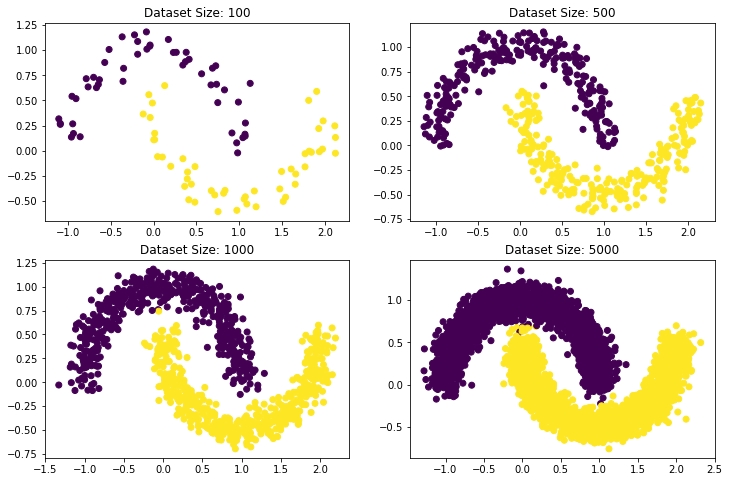

In [26]:
dataset_sizes = [100, 500, 1000, 5000]

# Generate datasets of varying sizes
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': torch.FloatTensor(X), 'y': y}

# Visualize the datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

Next we implement the Autoencoder class with variable length of hidden layers

In [33]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        encoder_layers = []
        decoder_layers = []
        
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size)) 
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Lets define the training function with the demanded parameters

In [59]:
# Training function
def train_autoencoder(model, datasets, dataset_size=1000, num_epochs=100, batch_size=32, learning_rate=0.001):
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader
    data_loader = torch.utils.data.DataLoader(datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for batch in data_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Checking training functionality:

In [60]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 100
layers = 2
dataset_size=1000

autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
train_autoencoder(autoencoder, datasets, dataset_size=1000,num_epochs=200)

Epoch [10/200], Loss: 0.0404
Epoch [20/200], Loss: 0.0163
Epoch [30/200], Loss: 0.0328
Epoch [40/200], Loss: 0.0089
Epoch [50/200], Loss: 0.0123
Epoch [60/200], Loss: 0.0027
Epoch [70/200], Loss: 0.0035
Epoch [80/200], Loss: 0.0049
Epoch [90/200], Loss: 0.0061
Epoch [100/200], Loss: 0.0144
Epoch [110/200], Loss: 0.0028
Epoch [120/200], Loss: 0.0110
Epoch [130/200], Loss: 0.0180
Epoch [140/200], Loss: 0.0159
Epoch [150/200], Loss: 0.0030
Epoch [160/200], Loss: 0.0048
Epoch [170/200], Loss: 0.0109
Epoch [180/200], Loss: 0.0086
Epoch [190/200], Loss: 0.0081
Epoch [200/200], Loss: 0.0035


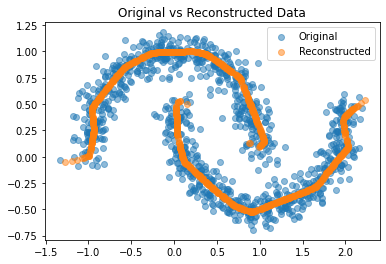

In [65]:
# Function to visualize original and reconstructed data
def visualize_results(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
    plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
    plt.title('Original vs Reconstructed Data')
    plt.legend()
    plt.show()

# Visualize results on the training dataset
visualize_results(autoencoder, datasets[dataset_size]['X'])

The Autoencoder seems to be working and reduces the mean squared reconstruction loss

In [67]:
autoencoder.decoder[0].in_features

1

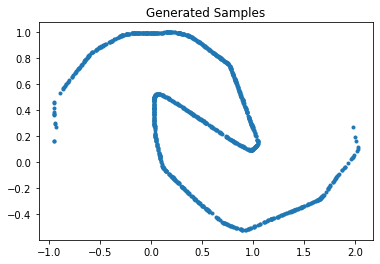

In [69]:
# Function to generate new samples using the trained autoencoder
def generate_samples(autoencoder, num_samples=1000):
    # Generate random samples in the latent space
    latent_samples = torch.randn(num_samples, 1)#, autoencoder.decoder[0].in_features)

    # Decode the samples
    generated_samples = autoencoder.decoder(latent_samples)

    return generated_samples.detach().numpy()

# Generate new samples using the trained autoencoder
generated_data = generate_samples(autoencoder, num_samples=1000)

# Visualize the generated samples
plt.scatter(generated_data[:, 0], generated_data[:, 1], marker='.')
plt.title('Generated Samples')
plt.show()